# Content based filtering #

The cells shown below are copied and used from other modules 

In [1]:
# import various dependencies and libraries
from pandas import Series, Timestamp, DataFrame
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import spacy

from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


In [2]:
def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

In [3]:
# Load data for town called York
data_path = './data/york/'

# Seperate the files 
review_file = 'review.json'
business_file = 'business.json'


reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file).set_index("business_id")

In [4]:
# divide the data in training- and testset, ratio 80/20
def split_data(data, d = 0.8):
    mask_test = np.random.rand(data.shape[0]) < d
    return data[mask_test], data[~mask_test]

reviews_training, reviews_test = split_data(reviews, d = 0.9)

In [5]:
# Pivot the dataframe so that the items are the reviews and the columns are the user_id's. The values are the ratings (stars)
# This results in an utility matrix that we can use for the predictions later down the line
def pivot_ratings(df):
    return df.pivot_table(values='stars', columns='user_id', index='review_id')

utility_ratings = pivot_ratings(reviews_training)
display(utility_ratings.head())

user_id,-2LWxpoon9RsfKASn0nagw,-EuhskKDtegbHRZ6jY8Hag,-FovbHo4EpqVAoSl613Ckw,-HyAR3KtHT2GT0N7oG1yMA,-KvhDluq5GhtiafY4xK2Sw,-LcGQs6kXkgqE72mh4Wg6A,-MeB9ToCwv4OMhLYKleG1w,-N9MxeH17Rl5kySQnifpmQ,-cESo1sunvLHDZEjgd7Lxg,-d2daWmftYumOaYpbD5D8Q,...,zT9WFNJXeQZBA-WJMsV4Zw,zU0Xa7707rL92KuL93hxDw,zVaPUVW9hnvQILEZadcdWQ,zcwSvdlg6nQsZU47c69aPg,zdFcdjBAX3G6c-rqrP0eXQ,zkKv10FEw-iWJBHvK0mGfA,zqr-argQ5KLB7Xqh9Pxj_A,zvQM_xPJcLZtpeMF4RoYCA,zwhRTdWy9CZz3kKNmQD1Ww,zyg4-MFtfPWmwucVazSjfw
review_id,,,,,,,,,,,,,,,,,,,,,
-4El6H8qdbhRSOBEIhKd3Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6YRBCn9sWq_Lep49Il9hA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-751yNyeGk31MzM1evM5nQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-C92XmV1yxIbdedK4Pn9pw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-EQAas184DtZOVEVLDQnuw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The functions shown below are taken and modified to fit in our case from bit.ly/2T8vnLe

In [6]:
# the TF-IDF vectorizer will convert the written reviews into numerical data. This can later be used in the cosine similarity matrix
TF_IDF = TfidfVectorizer(stop_words='english')

# Only reviews with more than 50 characters are used
reviews = reviews[reviews['text'].apply(lambda x: len(x)>50)]
reviews['text'] = reviews['text'].fillna('')

# Finally compute the TF-IDF matrix using the fit and transform method
tfidf_matrix = TF_IDF.fit_transform(reviews['text'])

In [7]:
# Now use the TF-IDF matrix with the cosine similarity using linear_kernel
similarity_matrix = DataFrame(linear_kernel(tfidf_matrix,tfidf_matrix))

# Put all the business_ids in a list
all_b_ids = list()
for i in reviews.values:
    all_b_ids.append(i[0])

data = similarity_matrix.values
similarity_matrix_content = DataFrame(index=all_b_ids, columns=all_b_ids, data=data)
display(similarity_matrix_content)

,2dNzapbJXDBh-X4hCC_yvQ,y5mSJmU58zi_yAVV0reneQ,83tzbgy8x4BdYfGas28ksg,dHCH_GqsEpN245wSQBCUog,HltszHwTQzC6A0xSs-kZ2w,zhKQUtpBkOMpBREia73nJA,S1R6Sh9khGZcojCGlfM0_Q,GZ1x8OcQ2Sx5B5DLDnqmAQ,_ARwg4Y2pUh3LEaagGLZlw,annRugVZ5CFGChTMaW7H-w,...,DR4n9QGK_mt0YWtu2gTa6A,d3p2C00beSZAgzukYnwotA,ephCY7d7w2bkU6tXSvSGVA,Ms3CWB8VrwSf7dBl8pvTnA,2AceAG_2qYDZot2kI5MmXg,guvR5FJNr7I8eKbyeHM2VA,gCQkA46E2n9MsqgaGK7gQg,9mnO2Xuc7_uyNNMlebKvuA,VwQAa7RdLXQ2Yc5VulgTow,0M4E6T9zJsjv0mH2qIEhdg
2dNzapbJXDBh-X4hCC_yvQ,1.000000,0.354752,0.000000,0.012419,0.000000,0.000000,0.000000,0.013719,0.000000,0.000000,...,0.000000,0.000000,0.040046,0.000000,0.000000,0.000000,0.000000,0.013805,0.038938,0.000000
y5mSJmU58zi_yAVV0reneQ,0.354752,1.000000,0.010984,0.006601,0.000000,0.013228,0.003718,0.000000,0.012936,0.000000,...,0.048902,0.009081,0.022031,0.000000,0.000000,0.019522,0.011165,0.006879,0.069514,0.000000
83tzbgy8x4BdYfGas28ksg,0.000000,0.010984,1.000000,0.000000,0.216577,0.029755,0.052865,0.033830,0.027961,0.000000,...,0.014421,0.013272,0.022752,0.010940,0.046409,0.126610,0.023625,0.014060,0.038206,0.025209
dHCH_GqsEpN245wSQBCUog,0.012419,0.006601,0.000000,1.000000,0.000000,0.225432,0.015898,0.041412,0.015633,0.000000,...,0.015246,0.029820,0.021240,0.012591,0.007011,0.007536,0.042975,0.015291,0.013924,0.014179
HltszHwTQzC6A0xSs-kZ2w,0.000000,0.000000,0.216577,0.000000,1.000000,0.000000,0.000000,0.000000,0.155788,0.000000,...,0.000000,0.000000,0.012144,0.000000,0.000000,0.100711,0.008956,0.000000,0.000000,0.012965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
guvR5FJNr7I8eKbyeHM2VA,0.000000,0.019522,0.126610,0.007536,0.100711,0.015103,0.007811,0.010937,0.034026,0.005486,...,0.008573,0.085938,0.023664,0.000000,0.009013,1.000000,0.045529,0.191800,0.026970,0.036945
gCQkA46E2n9MsqgaGK7gQg,0.000000,0.011165,0.023625,0.042975,0.008956,0.000000,0.018712,0.063849,0.014816,0.025438,...,0.000000,0.061930,0.007289,0.000000,0.006283,0.045529,1.000000,0.004958,0.007860,0.003133
9mnO2Xuc7_uyNNMlebKvuA,0.013805,0.006879,0.014060,0.015291,0.000000,0.034524,0.010630,0.011749,0.005204,0.000000,...,0.042245,0.061716,0.009186,0.003069,0.000000,0.191800,0.004958,1.000000,0.021881,0.035969
VwQAa7RdLXQ2Yc5VulgTow,0.038938,0.069514,0.038206,0.013924,0.000000,0.010329,0.008709,0.020702,0.017872,0.000000,...,0.017590,0.048381,0.042375,0.000000,0.008727,0.026970,0.007860,0.021881,1.000000,0.008336


In [8]:
# The function shown below is made for recommending business and it returns a list of business names based on similar reviews

# The function takes a review and a similarity_treshold as input
def recommend_business_list(review, similarity_treshold):
    mapping = Series(reviews_training.index, index=reviews_training['text'])
    rev_index = mapping[review]
    
    # match similarity values with other business
    # all similarity values are stored in a list
    similarity_score = list(enumerate(similarity_matrix[review]))
    
    # sort in descending order and put the similarity score of a business together with the other businesses
    similarity_score_sorted = sorted(similarity_score, key=lambda x:x[1], reverse=True)
    
    # Get similar similarity scores of businesses where similarity score is above threshold
    recom = list()
    for i in range(len(similarity_score_sorted)):
        if similarity_score_sorted[i][1] > similarity_treshold:
            recom.append(similarity_score_sorted[i])
    
    # find the ids of similar reviews

    review_ind = [i[0] for i in recom]
    similar_reviews = reviews['text'].iloc[review_ind].index
    
    sim_business, used_business = list(), list()
    
    for review_id in similar_reviews:
        business_id = reviews.loc[review_id]['business_id']
        if business_id not in used_business:
            used_business.append(business_id)
            
            sim_business.append(businesses.loc[business_id]['name'])
    
    return Series(sim_business)

In [9]:
recommend_business_list(100, 0.05)

0                            Z Bar & Grille
1                                 El Nahual
2                       Pegasus Bar & Grill
3                       First Class Delites
4                      Sky Ranch Restaurant
5     Churrasqueira Costa Verde BBQ Chicken
6                 Forest Hill Animal Clinic
7                      Jerusalem Restaurant
8      Commisso Bros & Racco Italian Bakery
9                              King Falafel
10                    California Sandwiches
11                  Raps Authentic Jamaican
12         Roti King West Indian Restaurant
13                       Urisha Investments
14                           Messina Bakery
15                         Randy's Take-Out
16                      Banaboia Restaurant
17             Doce Minho Pastry and Bakery
18               Sescolite Lighting Company
19                              Tokyo Sushi
20                              Pizza Pazza
21                Celebrity Pure Vegetarian
22                     Express T

In [10]:
# the predict ratings function below is taken and modified from module 3
def predict_ratings(similarity, utility, to_predict):
    ratings_test_c = to_predict.copy()
    ratings_test_c['predicted rating'] = to_predict.apply(lambda row: predict_ids(similarity, utility, row['user_id'], row['review_id']), axis=1)
    return ratings_test_c

def predict_ids(similarity, utility, user_id, review_id):
    if user_id in utility.columns and review_id in similarity.index:
        return predict_vectors(utility.loc[:,user_id], similarity[review_id])
    return np.nan

def predict_vectors(user_ratings, similarities):
    relevant_ratings = user_ratings.dropna()
    similarities_s = similarities[relevant_ratings.index].head(30)
    similarities_s = similarities_s[similarities_s > 0.0]
    relevant_ratings = relevant_ratings[similarities_s.index]
    norm = similarities_s.sum()
    if(norm == 0):
        return 0
    return np.dot(relevant_ratings, similarities_s)/norm

predicted_ratings = predict_ratings(similarity_matrix_content, utility_ratings, reviews_test).sort_values(by= "predicted rating", ascending = False).head(20)
display(predicted_ratings)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,predicted rating
259,DgVd2Dx_QKwwOF4V4NTIBg,Z06B0N794eSdQ_U8kx19DA,MWJg4LxOm9c7VGi1KrL5Ug,4.0,2,1,0,So this is my local Chinese takeout spot. I'm ...,2015-10-17 22:27:49,5.000000
781,D4EnQl1-Vgpfx0P-wxZM6w,RV0ljoUuwfkPYtzvT03W9g,sqFU1WIFbH_rrJJVHR4Z0g,5.0,1,0,0,Good selection of produce at great prices. Gre...,2016-10-17 22:08:55,5.000000
1199,e-gAumvxzmZZQG6Bw38R1A,MfWGWVuUo9bptZ9VcQTC5Q,OJamx7yKpYRXwfGWm2bFKw,5.0,5,1,3,"Though you might not think it possible, a Kore...",2010-01-20 11:50:32,5.000000
960,oCxhTGrayrSgs6GyC4w-YQ,5bYYUh8fqOOxJQwQotrkaw,8C1BoiaPma1VOu0FJT_7Sg,4.0,1,0,0,This one will be short and sweet. :-)\nWent w...,2013-09-27 17:08:34,5.000000
276,_IfMYAbGVukpoZChyHmGEA,mGzbJDzJND6VjP9myvl62g,0lQeZyb_jLHf44yBq7V5-g,5.0,0,0,0,This place may not be known for cleanliness bu...,2017-09-11 14:37:47,5.000000
563,T-DTKDkSSy8V7QjNK7TB9w,2e5V6M4GNufEnbGJpVdCjw,uuuNWBNHdYk8EOwjxmI8OA,5.0,0,1,0,"This is the best beef patties money can buy, p...",2013-09-20 05:41:43,5.000000
541,Dqxm8NnAcPPPTmveXfeDeQ,4qxKqtU_qZTLK52aV4pT5Q,4zmB6a8s6F-u46JYVixmrg,4.0,1,0,0,Courteous service with staff who seemed please...,2016-08-27 12:34:20,4.120827
23,a93K2bFSGXESk8bz2zr0uA,6UPWBTOfNoaGRahqTX14Ag,hcR-crK2l5L5suVgLSt7Jw,4.0,0,0,0,I didn't study here so can't attest to the aca...,2012-10-08 14:52:41,4.000000
246,pFuXRPFpFtzatRwRcIApjA,7fCPPXofWj2MWlfyKw1BFQ,NnJAsBJ7wGVNsQJnUsfEiQ,4.0,2,0,1,3.5 stars. I was a bit confused by the reviews...,2014-05-26 00:01:52,4.000000
332,lsaggASnf2Wfk7Zzk9dFyQ,zT9WFNJXeQZBA-WJMsV4Zw,A2a6fz8Us-ixv27d68vm9Q,4.0,1,2,1,"If you grow up in Canada, you probably learn t...",2008-09-29 12:49:15,4.000000


In [11]:
# the mse function below is taken and modified from module 3
def mse(predicted_ratings):
    """Computes the mean square error between actual ratings and predicted ratings
    
    Arguments:
    predicted_ratings -- a dataFrame containing the columns rating and predicted rating
    """
    diff = predicted_ratings['stars'] - predicted_ratings['predicted rating']
    return (diff**2).mean()
content_based_predicted = mse(predicted_ratings)

In [12]:
# The code below computes random prediction ratings and computes the mse over it
import random

random_mse = 0
predicted_random_training = reviews_training.copy()[['user_id', 'business_id', 'stars']]
predicted_random_training['predicted rating'] = np.random.randint(1,5)

random_mse = mse(predicted_random_training)

In [13]:
print(f'the mean squared error (mse) for content based prediction: {content_based_predicted:.2f}')
print(f'the mean squared error (mse) for random prediction: {random_mse:.2f}')


the mean squared error (mse) for content based prediction: 0.82
the mean squared error (mse) for random prediction: 9.12


# Precision-recall from old notebook #

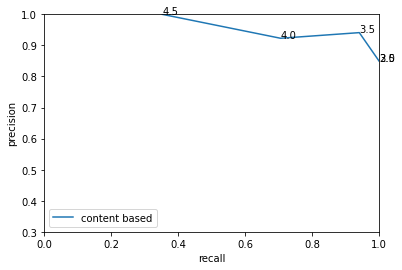

In [14]:
def recommended(predictions, treshold):
    return predictions.loc[predictions['predicted rating'] >= treshold]
    

def hidden(predictions, treshold):
    return predictions.loc[predictions['predicted rating'] < treshold]


def used(predictions, treshold):
    return predictions.loc[predictions['stars'] >= treshold]
    

def unused(predictions, treshold):
    return predictions.loc[predictions['stars'] < treshold]
    
    
def confusion(recommended, hidden, used, unused):
    # Compute cunfusion matrix values
    r_used = recommended[recommended.index.isin(list(used.index))].shape[0]
    r_unused = recommended[recommended.index.isin(list(unused.index))].shape[0]
    h_used = hidden[hidden.index.isin(list(used.index))].shape[0]
    h_unused = hidden[hidden.index.isin(list(unused.index))].shape[0]
    
    # Create Dataframe
    data = [(r_used, r_unused),
            (h_used, h_unused)]
    df_confusion = pd.DataFrame(data, columns=['used', 'unused'], index=['recommended', 'hidden'])
    
    # Return dataframe
    return df_confusion


def precision(confusion_matrix):
    # Compute counter and denominator
    counter = confusion_matrix['used']['recommended']
    denominator = confusion_matrix['used']['recommended'] + confusion_matrix['unused']['recommended']
    
    # Return 0 if counter or denomintor is 0
    if counter == 0 or denominator == 0:
        return 0.0
    # Return precision
    else:
        return counter / denominator


def recall(confusion_matrix):
    # COmpute counter and denominator
    counter = confusion_matrix['used']['recommended']
    denominator = confusion_matrix['used']['recommended'] + confusion_matrix['used']['hidden']
    
    # Return 0 if counter or denominator is 0
    if counter == 0 or denominator == 0:
        return 0.0
    # Return recall
    else:
        return counter / denominator


def make_cm(predictions, treshold_r, treshold_u):
    # Label ratings
    rec = recommended(predictions, treshold_r)
    hid = hidden(predictions, treshold_r)
    use = used(predictions, treshold_u)
    unu = unused(predictions, treshold_u)
    
    # Return confusion matrix
    cm = confusion(rec, hid, use, unu)
    return cm


# Set tresholds
treshold_used = 3.75
treshold_recommended = [2.5, 3.0, 3.5, 4.0, 4.5]

# Set databases
predicted_content_based = predicted_ratings.copy()
# predicted_item_based = df_predicted_cf_item_based.copy()

# Initialize lists
# lst_precision_item_based, lst_recall_item_based = list(), list()
lst_precision_content_based, lst_recall_content_based = list(), list()

for tre in treshold_recommended:
#     # Item based collaborative filtering
#     cm_item_based = make_cm(predicted_item_based, tre, treshold_used)
#     lst_precision_item_based.append(precision(cm_item_based))
#     lst_recall_item_based.append(recall(cm_item_based))

    # Content based filtering
    cm_content_based = make_cm(predicted_content_based, tre, treshold_used)
    lst_precision_content_based.append(precision(cm_content_based))
    lst_recall_content_based.append(recall(cm_content_based))

# # item based algorithm
# precisons = lst_precision_item_based
# recalls = lst_recall_item_based
# plt.plot(recalls, precisons)
# for r, p, t in zip(recalls, precisons, treshold_recommended):
#     plt.text(r, p, t)
    
# content based algorithm
precisons = lst_precision_content_based
recalls = lst_recall_content_based
plt.plot(recalls, precisons)
for r, p, t in zip(recalls, precisons, treshold_recommended):
    plt.text(r, p, t)

# Plot
plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['content based', 'content based'], loc = 'lower left')